In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable

# Read data

In [3]:
x_item_train = pd.read_csv('../../../data/input_formated/final/x_item_train.csv').iloc[:, 1:]
x_user_train = pd.read_csv('../../../data/input_formated/final/x_user_train.csv').iloc[:, 1:]
y_train = pd.read_csv('../../../data/input_formated/final/y_train.csv').iloc[:, 1:]

In [4]:
x_item_val = pd.read_csv('../../../data/input_formated/final/x_item_val.csv').iloc[:, 1:]
x_user_val = pd.read_csv('../../../data/input_formated/final/x_user_val.csv').iloc[:, 1:]
y_val_df = pd.read_csv('../../../data/input_formated/final/y_val.csv').iloc[:, 1:]
y_val = y_val_df

In [5]:
item_features = [u'category_Action', u'category_Adventure',
       u'category_Animation', u'category_Children\'s', u'category_Comedy',
       u'category_Crime', u'category_Documentary', u'category_Drama',
       u'category_Fantasy', u'category_Film-Noir', u'category_Horror',
       u'category_Musical', u'category_Mystery', u'category_Romance',
       u'category_Sci-Fi', u'category_Thriller', u'category_War',
       u'category_Western']

In [6]:
user_features = [u'occupation_0', u'occupation_1',
       u'occupation_2', u'occupation_3', u'occupation_4', u'occupation_5',
       u'occupation_6', u'occupation_7', u'occupation_8', u'occupation_9',
       u'occupation_10', u'occupation_11', u'occupation_12', u'occupation_13',
       u'occupation_14', u'occupation_15', u'occupation_16', u'occupation_17',
       u'occupation_18', u'occupation_19', u'occupation_20', u'age',
       u'gender']

In [7]:
target_features = ['rating']

In [8]:
x_0_train = np.array(x_item_train[item_features], dtype = np.float32)
x_1_train = np.array(x_user_train[user_features], dtype = np.float32)
y_train = np.array(y_train[target_features], dtype=np.float32).reshape((-1, 1))

In [9]:
x_0_val = np.array(x_item_val[item_features], dtype = np.float32)
x_1_val = np.array(x_user_val[user_features], dtype = np.float32)
y_val = np.array(y_val[target_features], dtype=np.float32).reshape((-1, 1))

In [20]:
x_0_train.shape

(143921, 18)

In [21]:
x_1_train.shape

(662577, 23)

# ANN

In [30]:
class ANN_2input(nn.Module):
    def __init__(self, input_0_size, input_1_size, hidden_size, merge_size, output_size):
        super(ANN_2input, self).__init__()
        self.fc0 = nn.Linear(input_0_size, hidden_size) 
        self.fc1 = nn.Linear(input_1_size, hidden_size)  
        self.activate0 = nn.Sigmoid()
        self.activate1 = nn.Sigmoid()
        self.fc_merge0 = nn.Linear(hidden_size, merge_size)
        self.fc_merge1 = nn.Linear(hidden_size, merge_size)
        self.bn_merge = nn.BatchNorm1d(merge_size, merge_size)
        self.activate_merge = nn.Sigmoid()
        self.fc = nn.Linear(merge_size, output_size)
        self.bn = nn.BatchNorm1d(output_size, output_size)
        self.activate = nn.Sigmoid()
        
        
    def forward(self, x_0, x_1):
        h_0 = self.activate0(self.fc0(x_0))
        h_1 = self.activate1(self.fc1(x_1))
        h = self.activate_merge(self.bn_merge(self.fc_merge0(h_0) + self.fc_merge1(h_1)))
        return self.activate(self.bn(self.fc(h)))

# Train

In [11]:
def mse_loss_vector(a, b):
    return torch.abs((a - b) * (a-b)).mean(dim = 0)

In [12]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

In [13]:
def val_error(model):
    inputs_0 = Variable(torch.from_numpy(np.array(x_0_val, dtype = np.float32)))
    inputs_1 = Variable(torch.from_numpy(np.array(x_1_val, dtype = np.float32)))
    outputs = model(inputs_0, inputs_1).data[:,0]
    tmp = y_val_df
    tmp['output'] = outputs
    target = np.array(tmp.groupby('movie_id')['mean_rate'].mean().reset_index() * 5, dtype = np.float32)[:, 1].reshape((-1, 1))
    output = np.array(tmp.groupby(['movie_id'])['output'].mean().reset_index() * 5, dtype = np.float32)[: ,1].reshape((-1,1))
    return np.sqrt(np.mean((target - output) * (target - output)))

In [28]:
def train(x_0_train, x_1_train, y_train, x_0_val, x_1_val, y_val, learning_rate, num_epochs, old_epochs, hidden_size, check_point = 100, model = None, model_save = None, max_patience = 200):
    merge_size = 10
    if model is None:
        model = ANN_2input(x_0_train.shape[1], x_1_train.shape[1],  hidden_size, merge_size, y_train.shape[1])
    
    # Loss and Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    train_loss_list, val_loss_list = [], []

    #early stopping
    patience = 0
    best_val = None
    model_best = None 
    
    # Train the Model 
    for epoch in range(num_epochs):
        # Convert numpy array to torch Variable
        inputs_0 = Variable(torch.from_numpy(x_0_train))
        inputs_1 = Variable(torch.from_numpy(x_1_train))
        targets = Variable(torch.from_numpy(y_train), requires_grad = False)

        # Forward + Backward + Optimize
        optimizer.zero_grad()  
        outputs = model(inputs_0, inputs_1)
        train_loss = mse_loss_vector(outputs, targets).sum()
        
        train_loss_list.append(train_loss.data[0])

        #validate
        inputs_0 = Variable(torch.from_numpy(x_0_val))
        inputs_1 = Variable(torch.from_numpy(x_1_val))
        targets = Variable(torch.from_numpy(y_val), requires_grad = False)
        outputs = model(inputs_0,inputs_1)   
        val_loss = mse_loss_vector(outputs, targets).sum()
        val_loss_list.append(val_loss.data[0])
        val_err = val_error(model)

        train_loss.backward()
        optimizer.step()

        if (epoch == 0) or ((epoch+1) % check_point == 0):
            print ('Epoch [%d/%d], Loss: %.4f, %.4f, Val Error: %.4f' 
                   %(epoch+1+old_epochs, num_epochs + old_epochs, train_loss.data[0], val_loss.data[0], val_err))
            if model_save is not None:
                torch.save(model, '%s_%d.pth' % (model_save, epoch + 1 + old_epochs))
        if (best_val is None) or ((best_val is not None) and (val_err < best_val)) :
            best_val = val_err
            patience = max_patience
            model_best = model
#             print 'Optimal: %d' % (epoch+1 + 5000)
        else:
            patience -= 1
        if patience == 0:
            print 'Early stopping at %d' % (epoch +1+ old_epochs)
            break            

    #Plot the graph
    plt.plot(range(len(val_loss_list)), train_loss_list, label='train')
    plt.plot(range(len(val_loss_list)), val_loss_list, label ='validate')
    
    plt.legend()
    plt.show()
    
    return model_best

In [33]:
model_ex1 = train(x_0_train, x_1_train, y_train, x_0_val, x_1_val, y_val,  learning_rate = 0.005, num_epochs= 500, old_epochs = 0, hidden_size = 40, check_point = 10, model_save='final_with-user/ex-1')

Epoch [1/500], Loss: 0.0971, 0.0943, Val Error: 0.9979
Epoch [10/500], Loss: 0.0923, 0.0896, Val Error: 0.9561
Epoch [20/500], Loss: 0.0871, 0.0844, Val Error: 0.9073
Epoch [30/500], Loss: 0.0821, 0.0794, Val Error: 0.8504
Epoch [40/500], Loss: 0.0776, 0.0748, Val Error: 0.7957
Epoch [50/500], Loss: 0.0737, 0.0711, Val Error: 0.7674
Epoch [60/500], Loss: 0.0702, 0.0680, Val Error: 0.7441
Epoch [70/500], Loss: 0.0672, 0.0652, Val Error: 0.7196
Epoch [80/500], Loss: 0.0647, 0.0628, Val Error: 0.7003
Epoch [90/500], Loss: 0.0624, 0.0606, Val Error: 0.6824
Epoch [100/500], Loss: 0.0604, 0.0587, Val Error: 0.6690
Epoch [110/500], Loss: 0.0586, 0.0570, Val Error: 0.6593
Epoch [120/500], Loss: 0.0571, 0.0556, Val Error: 0.6522
Epoch [130/500], Loss: 0.0558, 0.0544, Val Error: 0.6474
Epoch [140/500], Loss: 0.0547, 0.0533, Val Error: 0.6446
Epoch [150/500], Loss: 0.0537, 0.0524, Val Error: 0.6437
Epoch [160/500], Loss: 0.0528, 0.0517, Val Error: 0.6442
Epoch [170/500], Loss: 0.0521, 0.0510, Val

KeyboardInterrupt: 

Epoch [1/1200], Loss: 0.0971, 0.0943, Val Error: 0.9976
Epoch [10/1200], Loss: 0.0961, 0.0933, Val Error: 0.9891
Epoch [20/1200], Loss: 0.0950, 0.0922, Val Error: 0.9797
Epoch [30/1200], Loss: 0.0940, 0.0912, Val Error: 0.9703
Epoch [40/1200], Loss: 0.0929, 0.0901, Val Error: 0.9608
Epoch [50/1200], Loss: 0.0918, 0.0891, Val Error: 0.9509
Epoch [60/1200], Loss: 0.0908, 0.0880, Val Error: 0.9408
Epoch [70/1200], Loss: 0.0897, 0.0870, Val Error: 0.9300
Epoch [80/1200], Loss: 0.0886, 0.0859, Val Error: 0.9186
Epoch [90/1200], Loss: 0.0876, 0.0848, Val Error: 0.9065
Epoch [100/1200], Loss: 0.0865, 0.0837, Val Error: 0.8937
Epoch [110/1200], Loss: 0.0854, 0.0826, Val Error: 0.8807
Epoch [120/1200], Loss: 0.0844, 0.0816, Val Error: 0.8678
Epoch [130/1200], Loss: 0.0834, 0.0805, Val Error: 0.8557
Epoch [140/1200], Loss: 0.0825, 0.0796, Val Error: 0.8449
Epoch [150/1200], Loss: 0.0815, 0.0787, Val Error: 0.8356
Epoch [160/1200], Loss: 0.0806, 0.0778, Val Error: 0.8275
Epoch [170/1200], Loss: 0

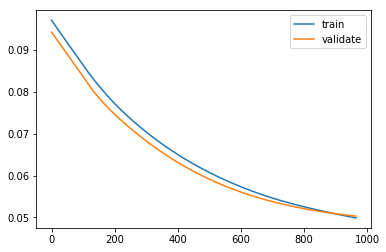

In [34]:
model_ex1 = train(x_0_train, x_1_train, y_train, x_0_val, x_1_val, y_val,  learning_rate = 0.001, num_epochs= 1200, old_epochs = 0, hidden_size = 40, check_point = 10, model_save='final_with-user/ex-2')

Epoch [1/1200], Loss: 0.0971, 0.0943, Val Error: 0.9977
Epoch [10/1200], Loss: 0.0961, 0.0933, Val Error: 0.9895
Epoch [20/1200], Loss: 0.0951, 0.0923, Val Error: 0.9805
Epoch [30/1200], Loss: 0.0940, 0.0912, Val Error: 0.9716
Epoch [40/1200], Loss: 0.0930, 0.0902, Val Error: 0.9628
Epoch [50/1200], Loss: 0.0919, 0.0892, Val Error: 0.9540
Epoch [60/1200], Loss: 0.0909, 0.0882, Val Error: 0.9452
Epoch [70/1200], Loss: 0.0899, 0.0873, Val Error: 0.9365
Epoch [80/1200], Loss: 0.0890, 0.0863, Val Error: 0.9277
Epoch [90/1200], Loss: 0.0880, 0.0853, Val Error: 0.9188
Epoch [100/1200], Loss: 0.0870, 0.0844, Val Error: 0.9097
Epoch [110/1200], Loss: 0.0860, 0.0834, Val Error: 0.9004
Epoch [120/1200], Loss: 0.0851, 0.0825, Val Error: 0.8907
Epoch [130/1200], Loss: 0.0841, 0.0815, Val Error: 0.8807
Epoch [140/1200], Loss: 0.0832, 0.0805, Val Error: 0.8704
Epoch [150/1200], Loss: 0.0822, 0.0796, Val Error: 0.8596
Epoch [160/1200], Loss: 0.0813, 0.0786, Val Error: 0.8486
Epoch [170/1200], Loss: 0

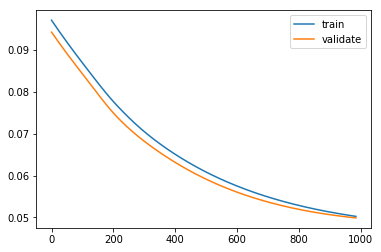

In [35]:
model_ex1 = train(x_0_train, x_1_train, y_train, x_0_val, x_1_val, y_val,  learning_rate = 0.001, num_epochs= 1200, old_epochs = 0, hidden_size = 10, check_point = 10, model_save='final_with-user/ex-2')